# Stage 2: Full Pipeline with Linear Model

# 1. Preprocessing 

## 1.1 Loading the data

In [1]:
# Imports
import os
import time
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
import shutil
from data.util import *
from data.transformer import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE,RFECV #importing RFE class from sklearn library
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
# load training and testing data into memory
root_path = "data"
X_train, s_train, y_train_str, p_train, i_train = TrainDataLoader(root_path).load()
X_test = TestDataLoader(root_path).load()
X_train, s_train, y_train_str, p_train, i_train = TrainDataLoader(root_path).load()

# X_train: all features (pixels x 3) of all training samples (4146)
# s_train: superclasses of all samples (4146); note ordered
# y_train: classes of all samples (4146); note ordered
# p_train: pole IDs of all samples (4146)
# i_train: indices of all samples (4146); note duplicates
# X_test: all features (pixels x 3) of all testing samples (4293)

# Make sure that you properly encode the CLASSES such that 
# the order in your submission files is correct!
label_enc = LabelEncoder()
label_enc.fit(CLASSES)
y_train = label_enc.transform(y_train_str) # numerical labels
    
# Randomizer
numpy_seed = 0
python_seed = 0
np.random.seed(numpy_seed)
random.seed(python_seed)

In [3]:
# display some numbers
number_of_train_samples = len(X_train)
number_of_classes = len(np.unique(y_train))
number_of_test_samples = len(X_test)
print('number of training samples:', number_of_train_samples)
print('number of testing samples:', number_of_test_samples)
print('number of labels:', number_of_classes)

number of training samples: 4146
number of testing samples: 4293
number of labels: 81


## 1.2 Class distribution

FileNotFoundError: [Errno 2] No such file or directory: 'visualization\\class_distribution.png'

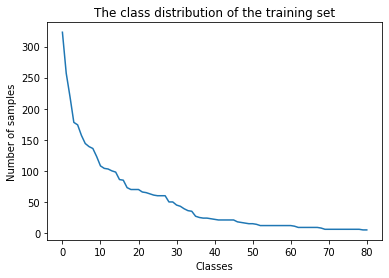

In [8]:
# Create a plot showing the class distribution in the training set
fig_distr, ax_distr = plt.subplots()
ax_distr.set_title("The class distribution of the training set")
ax_distr.set_xlabel("Classes")
ax_distr.set_ylabel("Number of samples")

count = countOcc(y_train)
plt.plot([i for i in range(len(count))], count);
fig_distr.savefig(os.path.join('visualization','class_distribution.png'))

## 1.3 Improve contrast (CLAHE)

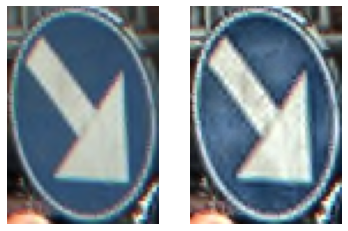

In [9]:
X_train_contr = ContrastTransformer().transform(X_train)
X_test_contr = ContrastTransformer().transform(X_test)

# Show effect of improving contrast
image_index = 99
image_ori = Image.fromarray(X_train[image_index])
image_con = Image.fromarray(X_train_contr[image_index])

# create figure and show images
fig_con, ax_con = plt.subplots(1,2)
ax_con[0].imshow(image_ori)
ax_con[1].imshow(image_con)
ax_con[0].set_axis_off()
ax_con[1].set_axis_off()

## 1.4 Resize all images to a fixed resolution

(4146, 64, 64, 3)
(4293, 64, 64, 3)


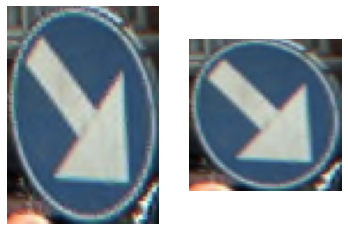

In [11]:
X_train_resized = ResizeTransformer().transform(X_train)
X_test_resized = ResizeTransformer().transform(X_test)
print(X_train_resized.shape)
print(X_test_resized.shape)

# Show effect of resizing
image_index = 99
image_ori = Image.fromarray(X_train[image_index])
image_res = Image.fromarray(X_train_resized[image_index])
# create figure and show images
fig_res, ax_res = plt.subplots(1,2)
ax_res[0].imshow(image_ori)
ax_res[1].imshow(image_res)
ax_res[0].set_axis_off()
ax_res[1].set_axis_off()


# 2. Feature Extraction

## 2.1. Color Histograms

4716.314327478409
(4146, 27)
(4293, 27)


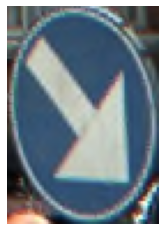

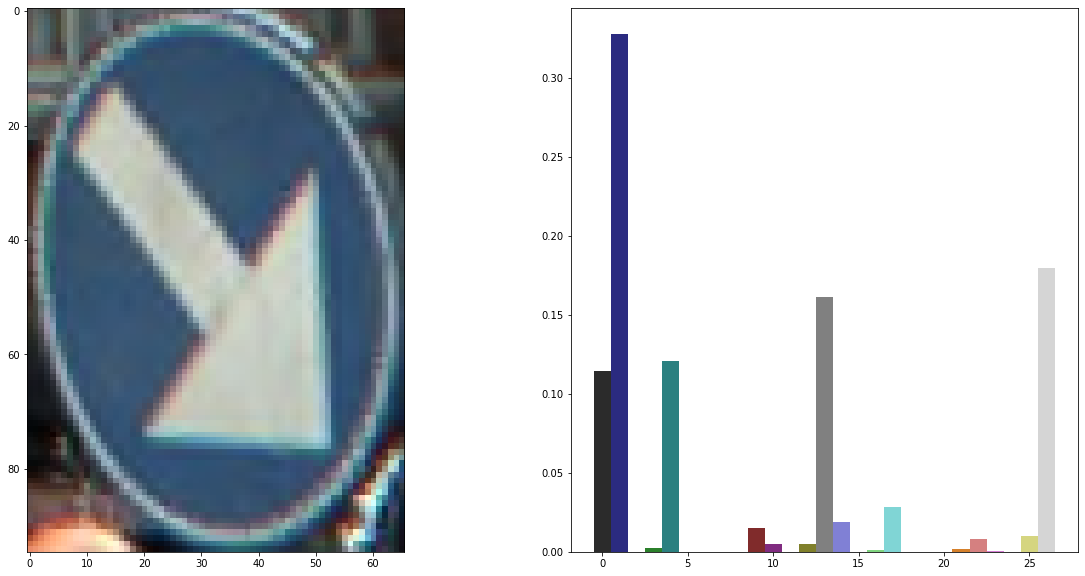

In [40]:
nbinh=3
X_train_hist = colorhistTransformer(nbin=nbinh).transform(X_train)
X_test_hist = colorhistTransformer(nbin=nbinh).transform(X_test)
print(time.time()-start)
print(X_train_hist.shape)
print(X_test_hist.shape)

# Show corresponding image
image_index = 99
image_ori = Image.fromarray(X_train[image_index])
# create figure and show images
fig_rgb, ax_rgb = plt.subplots()
ax_rgb.imshow(image_ori)
ax_rgb.set_axis_off()

def image_plot(hist,image,colors):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(len(hist)),hist,width=1,color=colors,linewidth=0)
colors=[]
for r in np.arange(0.5,nbinh+0.5):
    for g in np.arange(0.5,nbinh+0.5):
        for b in np.arange(0.5,nbinh+0.5):
            colors.append((r/nbinh,g/nbinh,b/nbinh))
image_plot(X_train_hist[image_index],X_train[image_index],colors*256)

## 2.2 HOG features

In [17]:
# Test resize
for size in [64,128]:
    X_resized = ResizeTransformer(size=size).transform(X_train)
    X_hog = HogTransformer(resize=True).transform(X_resized)
    print(X_train[0].shape, X_resized[0].shape, X_hog[0].shape)

X_train_hog = HogTransformer().transform(X_train_resized)
X_test_hog = HogTransformer().transform(X_test_resized)
print(X_train_hog.shape)
print(X_test_hog.shape)

(114, 118, 3) (64, 64, 3) (576,)
(114, 118, 3) (128, 128, 3) (576,)
(4146, 576)
(4293, 576)


(576,)


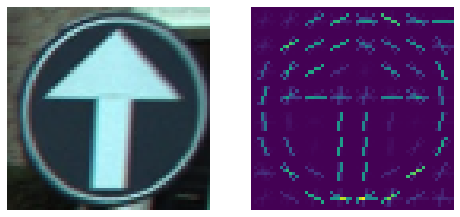

In [18]:
# visualization of HOG features (NOTE: uses skimage HOG)
from skimage.feature import hog

image_index = 7
image_original = X_train_resized[image_index]
fd, image_hog = hog(image_original, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(8, 8), visualize=True, multichannel=True)

fig_hog, ax_hog = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax_hog[0].imshow(image_original)
ax_hog[1].imshow(image_hog)
ax_hog[0].set_axis_off()
ax_hog[1].set_axis_off()
print(fd.shape)

# 3. Feature Visualization

## 3.1 Histogram for 1 feature
A histogram that plots the number of samples with certain HOG values for 1 specific HOG feature.

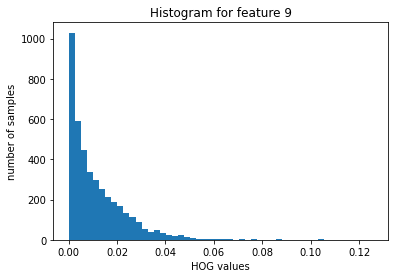

In [19]:
# Visualize the histogram for a specific feature
feature_index = 9
feature = X_train_hog[:,feature_index]
fig_feat, ax_feat = plt.subplots()
ax_feat.set_title("Histogram for feature {}".format(feature_index))
ax_feat.set_xlabel("HOG values")
ax_feat.set_ylabel("number of samples")
plot_histogram(ax_feat, feature, bins=50)

## 3.2 Histogram for 1 sample
A histogram that plots the number of features with certain HOG values for 1 specific sample. There's also a function implemented to plot histograms for multiple samples. This is to visually check for correlations between samples and try to understand what the poleIDs and IDs play as roles in the dataset.
Note that samples with different poleIDs but identical IDs have (visually) identical histograms. This implies a correlation between these samples.

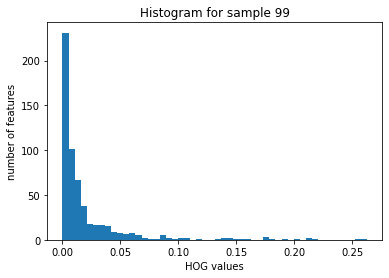

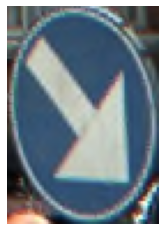

In [20]:
# Visualize the histogram for a specific sample
sample_index = 99
sample = X_train_hog[sample_index,:]
image = Image.fromarray(X_train[sample_index])
#image.show() # uncomment to show corresponding images
fig_samp, ax_samp = plt.subplots()
ax_samp.set_title("Histogram for sample {}".format(sample_index))
ax_samp.set_xlabel("HOG values")
ax_samp.set_ylabel("number of features")
plot_histogram(ax_samp, sample, bins=50)
fig_im, ax_im = plt.subplots()
ax_im.imshow(image)
ax_im.set_axis_off()

## 3.3. Feature Combination

In [21]:
clf_lr = LogisticRegression(max_iter=1000, n_jobs=-2)  
rfe = RFE(estimator= clf_lr , step =50)  
# inx=np.random.randint(0,len(X_train)-1,1000)
# fit = rfe.fit(X_train_hog[inx,:], y_train[inx])

X_train_hog_hist = np.concatenate((X_train_hog, X_train_hist), axis=1)
X_test_hog_hist = np.concatenate((X_test_hog, X_test_hist), axis=1)
print(X_train_hog_hist.shape)
print(X_test_hog_hist.shape)

(4146, 603)
(4293, 603)


## 3.4. Feature Correlations
Supervised feature selection method which looks at the correlation between feature pairs. Different correlation coefficient calculation methods are available.

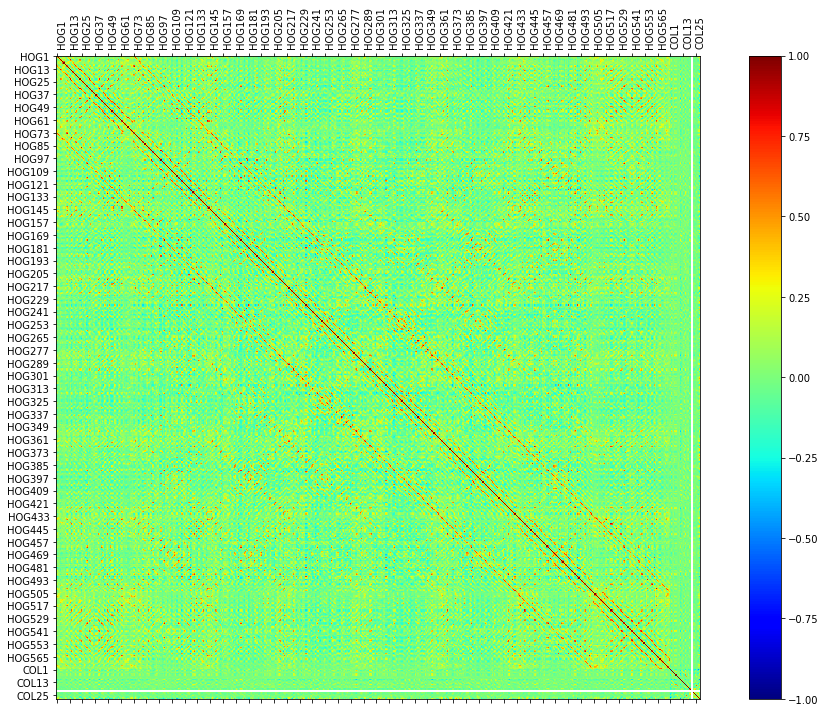

In [22]:
# turn numpy X_train into pd dataframe and add column with labels
row_names = [i for i in range(1,number_of_train_samples+1)]
column_names = ['HOG'+ str(i) for i in range(1,X_train_hog.shape[1]+1)]
column_names += ['COL' + str(i) for i in range(1,nbinh**3+1) ]
pd_X_train_hog_hist = pd.DataFrame(data=X_train_hog_hist, 
                                  index=row_names,
                                        columns=column_names)
pd_X_train_hog_hist['class'] = y_train
pd_X_train_hog_hist.head()
plot_correlation_matrix(pd_X_train_hog_hist)

In [23]:
# You can check the # of ftrs eleminated by transformming 
for t in [.75]:#,.8,.85,.9
    X_train_corrTrunc = CorrMatrixTransformer(treshold=t).transform(X_train_hog, y_train)
    print(f'Threshold value {t}')
    print(X_train_corrTrunc.shape)

Using Correlation matrix: removed 147 features.
Threshold value 0.75
(4146, 430)


In [121]:
# cross validation strategy -- stratified and grouped
cv_indices = []
folds = 5
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
for train_fold, test_fold in sgkf:
    cv_indices.append((train_fold, test_fold))

# 4. Pipeline

## 4.1 Untuned model

In [15]:
pipeline_select_hog = Pipeline([('select_resize', ResizeTransformer()),
                                ('select_hog', HogTransformer())
                               ])
pipeline_select_colorhist = Pipeline([('select_colorhist', colorhistTransformer())])

pipeline = Pipeline([('select_feat', FeatureUnion([('select_hog', pipeline_select_hog),
                                                      ('select_colorhist', pipeline_select_colorhist)
                                                 ])),
                     
                    ('scale_std', StandardScaler()),
                    ('classify_lr', LogisticRegression(max_iter=1000, n_jobs=-2))
                    ])

folds = 5

sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
scores = cross_validate(pipeline, X_train, y_train, groups=p_train,
                            cv=sgkf, scoring=neg_logloss_scorer, return_train_score=True)
show_scores(scores)

Training score -0.0029527334671348524 +/- 0.0001019479839130303
Cross-validation score: -0.25431759219581573 +/- 0.07181801377240575


## 4.2. Tuned model
Tuning of the hyperparameters happens here. Before we can start doing this, we should first evaluate the model using the train-CV and CV-test gaps as well as the learning curves. 

In [30]:
# standard scaler pipeline (NOTE: doesn't contain color histograms yet)
pipeline_select_hog = Pipeline([('resize', ResizeTransformer()),
                                ('hog', HogTransformer()),
                               ])
pipeline_select_colorhist = Pipeline([('colorhist', colorhistTransformer())])

pipeline = Pipeline([('features', pipeline_select_hog),
                    ('scalar', StandardScaler()),
                    ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))
                    ])
# pipeline = Pipeline([('features', pipeline_select_colorhist),
#                     ('scalar', StandardScaler()),
#                     ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))
#                     ])

# show all available parameters
print(pipeline.get_params())
print('')

# tuning ranges
resize_range = [16,32,64,128,256] # use this with hog__resize : [True]
boolean = [True, False]
lr_weights = ['balanced', None]
lr_C = [.001,.01,.1,1,100]
lr_class = ['ovr', 'multinomial']
hog_sizes = [(64,64),(8,8),(16,16),(32,32)]
hog_bins = [ 5, 7, 9, 11, 13]
hist_bin=[2,3,4,5]
lda_solvers = ['svd', 'lsqr', 'eigen']
lda_shrinkage = np.arange(0, 1,.2)
corr_trorr_treshold = [.02]
corr_method_list = ['pearson', 'ken# dall', 'spearman'] 

 
param_grid = {'features__resize__size':resize_range,
              'features__hog__resize': [True],
              'logreg__C':lr_C}





# ##  perform g# rid search
# folds = 5
# sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
# grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=sgkf, 
#                             scoring=neg_logloss_scorer, verbose=True, 
#                             n_jobs=-2, return_train_score=True)
# grid_search.fit(X_train, y_train, groups=p_train)
# show_grid_scores(grid_search)

# # get best model and calculate score
# estimator = get_best_model(grid_search)
# sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
# scores = cross_validate(estimator, X_train, y_train, groups=p_train, 
#                         cv=sgkf, scoring=neg_logloss_scorer, return_train_score=True)
# show_scores(scores)
folds =5


{'memory': None, 'steps': [('features', Pipeline(steps=[('resize', ResizeTransformer()), ('hog', HogTransformer())])), ('scalar', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))], 'verbose': False, 'features': Pipeline(steps=[('resize', ResizeTransformer()), ('hog', HogTransformer())]), 'scalar': StandardScaler(), 'logreg': LogisticRegression(max_iter=1000, n_jobs=-2), 'features__memory': None, 'features__steps': [('resize', ResizeTransformer()), ('hog', HogTransformer())], 'features__verbose': False, 'features__resize': ResizeTransformer(), 'features__hog': HogTransformer(), 'features__resize__size': 64, 'features__hog__blockSize': 64, 'features__hog__blockStride': 64, 'features__hog__cellSize': 8, 'features__hog__nbins': 9, 'features__hog__resize': False, 'features__hog__winSize': 64, 'scalar__copy': True, 'scalar__with_mean': True, 'scalar__with_std': True, 'logreg__C': 1.0, 'logreg__class_weight': None, 'logreg__dual': False, 'logreg__fit_intercept': Tru

# 5. Model Evaluation

## 5.1. Validation Curve

In [32]:
# standard scaler pipeline (NOTE: doesn't contain color histograms yet)
pipeline_select_hog = Pipeline([('select_resize', ResizeTransformer()),
                                ('select_hog', HogTransformer()),
                               ])
pipeline_select_colorhist = Pipeline([('select_colorhist', colorhistTransformer())])

# pipeline = Pipeline([('select_feat', pipeline_select_hog),
#                     ('scale_std', StandardScaler()),
#                     ('classify_lr', LogisticRegression(max_iter=1000, n_jobs=-2))
#                     ])
pipeline = Pipeline([('select_feat', pipeline_select_colorhist),
                    ('scale_std', StandardScaler()),
                    ('classify_lr', LogisticRegression(max_iter=2000, n_jobs=-2))
                    ])


# show all available parameters
print(pipeline.get_params())
print('')

# tuning ranges
boolean = [True, False]
lr_weights = ['balanced', None]
lr_C = [0.0001,0.001,0.01,0.1,1,10,100]
lr_class = ['ovr', 'multinomial']
hog_sizes = [(64,64),(8,8)]
hog_bins = [ 9,11,13,15]
hist_bin=[2,3,4,5,6]
lda_solvers = ['svd', 'lsqr', 'eigen']
lda_shrinkage = np.arange(0, 1, 0.2)
corr_treshold = [.8,.85,.9]
corr_treshold = [.02]
corr_method_list = ['pearson', 'kendall', 'spearman'] 

# parameter grid
param_grid = {'classify_lr__C':lr_C}
# param_grid = {'select_feat__select_hog__nbins':hog_bins,
#               'classify_lr__C':lr_C} # medium search
param_grid = {'select_feat__select_colorhist__nbin':hist_bin,
              'classify_lr__C':lr_C} # medium search

# perform grid search
folds = 5
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=sgkf, 
                            scoring=neg_logloss_scorer, verbose=True, 
                            n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train, groups=p_train)
show_grid_scores(grid_search)

# get best model and calculate score
estimator = get_best_model(grid_search)
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
scores = cross_validate(estimator, X_train, y_train, groups=p_train, 
                        cv=sgkf, scoring=neg_logloss_scorer, return_train_score=True)
show_scores(scores)

{'memory': None, 'steps': [('select_feat', Pipeline(steps=[('select_colorhist', colorhistTransformer())])), ('scale_std', StandardScaler()), ('classify_lr', LogisticRegression(max_iter=2000, n_jobs=-2))], 'verbose': False, 'select_feat': Pipeline(steps=[('select_colorhist', colorhistTransformer())]), 'scale_std': StandardScaler(), 'classify_lr': LogisticRegression(max_iter=2000, n_jobs=-2), 'select_feat__memory': None, 'select_feat__steps': [('select_colorhist', colorhistTransformer())], 'select_feat__verbose': False, 'select_feat__select_colorhist': colorhistTransformer(), 'select_feat__select_colorhist__nbin': 4, 'scale_std__copy': True, 'scale_std__with_mean': True, 'scale_std__with_std': True, 'classify_lr__C': 1.0, 'classify_lr__class_weight': None, 'classify_lr__dual': False, 'classify_lr__fit_intercept': True, 'classify_lr__intercept_scaling': 1, 'classify_lr__l1_ratio': None, 'classify_lr__max_iter': 2000, 'classify_lr__multi_class': 'auto', 'classify_lr__n_jobs': -2, 'classify

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed: 32.7min finished


Grid scores on training data set:
-3.831 (+/-0.226) for {'classify_lr__C': 0.0001, 'select_feat__select_colorhist__nbin': 2}
-3.815 (+/-0.226) for {'classify_lr__C': 0.0001, 'select_feat__select_colorhist__nbin': 3}
-3.794 (+/-0.227) for {'classify_lr__C': 0.0001, 'select_feat__select_colorhist__nbin': 4}
-3.772 (+/-0.222) for {'classify_lr__C': 0.0001, 'select_feat__select_colorhist__nbin': 5}
-3.748 (+/-0.219) for {'classify_lr__C': 0.0001, 'select_feat__select_colorhist__nbin': 6}
-3.704 (+/-0.231) for {'classify_lr__C': 0.001, 'select_feat__select_colorhist__nbin': 2}
-3.599 (+/-0.227) for {'classify_lr__C': 0.001, 'select_feat__select_colorhist__nbin': 3}
-3.506 (+/-0.224) for {'classify_lr__C': 0.001, 'select_feat__select_colorhist__nbin': 4}
-3.432 (+/-0.230) for {'classify_lr__C': 0.001, 'select_feat__select_colorhist__nbin': 5}
-3.374 (+/-0.226) for {'classify_lr__C': 0.001, 'select_feat__select_colorhist__nbin': 6}
-3.357 (+/-0.237) for {'classify_lr__C': 0.01, 'select_feat__

In [39]:
# validation curves for 2 dimensional grid search, containing C
print(grid_search.cv_results_._best_index_)
plot_grid_search(grid_search.cv_results_, param_grid)

AttributeError: 'dict' object has no attribute '_best_index_'

In [31]:
# validation curve for 1 dimensional grid search, any hyperparameter
# Note: this performs a gridsearch and is very slow
param_grid = {'features__resize__size':resize_range,
              'features__hog__resize': [True],
              'logreg__C':lr_C}
param_name = 'features__resize__size'
param_range = param_grid[param_name]
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
valid_curv = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range, 
                               cv=sgkf, groups=p_train, scoring=neg_logloss_scorer, 
                                   n_jobs=-2)
plot_validation_curve(valid_curv, param_name, param_range)

NameError: name 'estimator' is not defined

In [ ]:
pipeline_select_hog = Pipeline([('resize', ResizeTransformer()),
                                ('hog', HogTransformer()),
                                ('corr', CorrMatrixTransformer())
                               ])

pipeline = Pipeline([('features', pipeline_select_hog),
                    ('scalar', StandardScaler()),
                    ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))
                    ])

param_grid = {'features__hog__nbins':[7],
              'features__corr__treshold': [.6,.7,.8,.85,.9],
              'logreg__C':lr_C}


folds = 5
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=sgkf, 
                            scoring=neg_logloss_scorer, verbose=True, 
                            n_jobs=-2, return_train_score=True)
grid_search.fit(X_train, y_train, groups=p_train)
show_grid_scores(grid_search)

# get best model and calculate score
estimator = get_best_model(grid_search)
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
scores = cross_validate(estimator, X_train, y_train, groups=p_train, 
                        cv=sgkf, scoring=neg_logloss_scorer, return_train_score=True)
show_scores(scores)                    

param_name = 'features__corr__treshold'
param_range = param_grid[param_name]
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
valid_curv = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range, 
                               cv=sgkf, groups=p_train, scoring=neg_logloss_scorer, 
                                   n_jobs=-2)
plot_validation_curve(valid_curv, param_name, param_range)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  4.6min


In [ ]:
pipeline_select_hog = Pipeline([('resize', ResizeTransformer()),
                                ('hog', HogTransformer()),
                               ])

pipeline = Pipeline([('features', pipeline_select_hog),
                    ('scalar', StandardScaler()),
                    ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))
                    ])

param_grid = {'features__hog__cellSize':hog_sizes,
              'logreg__C':lr_C}


folds = 5
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=sgkf, 
                            scoring=neg_logloss_scorer, verbose=True, 
                            n_jobs=-2, return_train_score=True)
grid_search.fit(X_train, y_train, groups=p_train)
show_grid_scores(grid_search)

# get best model and calculate score
estimator = get_best_model(grid_search)
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
scores = cross_validate(estimator, X_train, y_train, groups=p_train, 
                        cv=sgkf, scoring=neg_logloss_scorer, return_train_score=True)
show_scores(scores)                    

param_name = 'features__hog__cellSize'
param_range = param_grid[param_name]
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
valid_curv = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range, 
                               cv=sgkf, groups=p_train, scoring=neg_logloss_scorer, 
                                   n_jobs=-2)
plot_validation_curve(valid_curv, param_name, param_range)

In [103]:
# Optimized parameters:
# winSize=32,blockSize=32, blockStride=2, cellSize=8,nbins=15
X_train_resized=ResizeTransformer(size=64).transform(X_train)
X_test_resized=ResizeTransformer(size=64).transform(X_test)

X_train_hog = HogTransformer(winSize=32, blockSize=32, blockStride=2, cellSize=8, nbins=15).transform(X_train_resized)
X_test_hog = HogTransformer(winSize=32, blockSize=32, blockStride=2, cellSize=8, nbins=15).transform(X_test_resized)


X_train_color = colorhistTransformer(nbin=4).transform(X_train)
X_test_color = colorhistTransformer(nbin=4).transform(X_test)

X_train_tuned = np.concatenate((X_train_hog, X_train_color), axis=1)
X_test_tuned = np.concatenate((X_test_hog, X_test_color), axis=1)
print(np.shape(X_test_tuned))


(4293, 6064)


In [ ]:
pipeline = Pipeline([('scalar', StandardScaler()),
                    ('classify_lr', LogisticRegression(max_iter=1000, n_jobs=-2))
                    ])

# tuning ranges
lr_C = [0.01, 0.1, 1, 10]

# parameter grid

param_grid = {'classify_lr__C':lr_C} # short search

# perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_indices, 
                            scoring=neg_logloss_scorer, verbose=True, 
                            n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_tuned, y_train, groups=p_train)
show_grid_scores(grid_search)

# get best model and calculate score
estimator = get_best_model(grid_search)
scores = cross_validate(estimator, X_train_tuned, y_train, groups=p_train, 
                        cv=cv_indices, scoring=neg_logloss_scorer, return_train_score=True)
show_scores(scores)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 25.2min finished


In [134]:
pipeline_select_hog = Pipeline([('resize', ResizeTransformer()),
                                ('hog', HogTransformer())
                               ])
pipeline_select_colorhist = Pipeline([('select_colorhist', colorhistTransformer())])

pipeline_select_features = FeatureUnion([('hog_select',pipeline_select_hog),('color_select',pipeline_select_colorhist)])

pipeline = Pipeline([('features',pipeline_select_features),
                    ('scalar', StandardScaler()),
                    ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))
                    ])

# show all available parameters
print(pipeline.get_params())


# # tuned parameters
# # lr_weights = ['balanced', None]
# # boolean = [True, False]

resize_range = [64] # use this with hog__resize : [True]
hog__blockSize = [32]
hog__blockStride=[2]
hog__cellSize = [8]
hog__winSize = [32]
hog__nbins = [15]
nbin = [4]

lr_C = [0.01, 0.1, 1, 10, 100]

param_grid = {'features__hog_select__resize__size':resize_range,
              'features__hog_select__hog__blockSize':hog__blockSize,
              'features__hog_select__hog__blockStride':hog__blockStride,
              'features__hog_select__hog__cellSize':hog__cellSize,
              'features__hog_select__hog__winSize':hog__winSize,
              'features__hog_select__hog__nbins':hog__nbins,
              'features__color_select__select_colorhist__nbin':nbin,
              'logreg__C':lr_C}
# perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_indices, 
                            scoring=neg_logloss_scorer, verbose=True, 
                            n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train, groups=p_train)
show_grid_scores(grid_search)

# get best model and calculate score
estimator = get_best_model(grid_search)
scores = cross_validate(estimator, X_train, y_train, groups=p_train, 
                        cv=cv_indices, scoring=neg_logloss_scorer, return_train_score=True)
show_scores(scores)



{'memory': None, 'steps': [('features', FeatureUnion(transformer_list=[('hog_select',
                                Pipeline(steps=[('resize', ResizeTransformer()),
                                                ('hog', HogTransformer())])),
                               ('color_select',
                                Pipeline(steps=[('select_colorhist',
                                                 colorhistTransformer())]))])), ('scalar', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000, n_jobs=-2))], 'verbose': False, 'features': FeatureUnion(transformer_list=[('hog_select',
                                Pipeline(steps=[('resize', ResizeTransformer()),
                                                ('hog', HogTransformer())])),
                               ('color_select',
                                Pipeline(steps=[('select_colorhist',
                                                 colorhistTransformer())]))]), 'scalar': StandardScaler(), 'logreg': 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 28.0min finished


Grid scores on training data set:
-0.226 (+/-0.133) for {'features__color_select__select_colorhist__nbin': 4, 'features__hog_select__hog__blockSize': 32, 'features__hog_select__hog__blockStride': 2, 'features__hog_select__hog__cellSize': 8, 'features__hog_select__hog__nbins': 15, 'features__hog_select__hog__winSize': 32, 'features__hog_select__resize__size': 64, 'logreg__C': 0.01}
-0.200 (+/-0.134) for {'features__color_select__select_colorhist__nbin': 4, 'features__hog_select__hog__blockSize': 32, 'features__hog_select__hog__blockStride': 2, 'features__hog_select__hog__cellSize': 8, 'features__hog_select__hog__nbins': 15, 'features__hog_select__hog__winSize': 32, 'features__hog_select__resize__size': 64, 'logreg__C': 0.1}
-0.202 (+/-0.143) for {'features__color_select__select_colorhist__nbin': 4, 'features__hog_select__hog__blockSize': 32, 'features__hog_select__hog__blockStride': 2, 'features__hog_select__hog__cellSize': 8, 'features__hog_select__hog__nbins': 15, 'features__hog_selec

C:\Users\rchaudha\.conda\envs\base2\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rchaudha\.conda\envs\base2\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rchaudha\.conda\envs\base2\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\rchaudha\.conda\envs\base2\lib\site-packages\sklearn\pipeline.py", line 296, in _fit
    **fit_params_steps[name])
  File "C:\Users\rchaudha\.conda\envs\base2\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\rchaudha\.conda\envs\base2\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer

Training score nan +/- nan
Cross-validation score: nan +/- nan


## 5.2. Learning Curve

In [ ]:
# calculate and plot learning curve
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
learn_curv = learning_curve(estimator, X_train, y_train, train_sizes=np.linspace(.1, 1.0, 5),
                                cv=sgkf, groups=p_train, scoring=neg_logloss_scorer, 
                                    n_jobs=-2, shuffle=True)
plot_learning_curve(learn_curv)

## 5.3. Confusion Matrix

In [ ]:
# do a train-test split; stratified and grouped
sgkf_conf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
numpy_classes=np.array(CLASSES)
n=1
for train_index, test_index in sgkf_conf: # remember that this contains k folds
    train_indices, test_indices = train_index, test_index # only remember the last one
    # train estimator on training data
    estimator.fit(np.array(X_train, dtype=object)[train_indices], y_train[train_indices])
    # predict class on cross-validation data
    y_pred = estimator.predict(np.array(X_train, dtype=object)[test_indices])
    y_true = y_train[test_indices]
    print(np.concatenate((numpy_classes[y_true[y_pred!=y_true].astype(int)].reshape(-1,1),numpy_classes[y_pred[y_pred!=y_true].astype(int)].reshape(-1,1)),axis=1))
    conf_matr = confusion_matrix(y_true, y_pred, normalize='true') # normalised
    plot_confusion_matrix(conf_matr, n)
    n+=1

In [ ]:
numpy_classes=np.array(CLASSES)
print(np.concatenate((numpy_classes[y_true[y_pred!=y_true].astype(int)].reshape(-1,1),numpy_classes[y_pred[y_pred!=y_true].astype(int)].reshape(-1,1)),axis=1))

# 6. Submission

In [ ]:
# train best model using all training data
estimator.fit(X_train, y_train)
# Here is where we create the submission for your estimator
output_probabilities = estimator.predict_proba(X_test)
create_submission(output_probabilities, 'submission.csv')